# Data versioning - why does it matter?

Data versioning is critical for model debugging and reproducibility. <br/>
With each iteration, you need to be able to:
- understand whether paying more $ for labels actually matter
- explain *why* the model performance is changing
- pin-point problems in the new data that's causing regressions

## Lance to the rescue

- Lance supports data versioning natively and transparently
- Versions are automatically created as the dataset changes
- Different versions are concurrently queryable without complicate "git checkout semantics"

Setup venv

```sh
python3 -m venv ~/.venv/lance
source ~/.venv/lance/bin/activate
pip install jupyter
jupyter notebook  # in the same directory as this notebook
```

Install dependencies

In [1]:
# Add --quiet after install if you don't want to see the output
!pip install pylance duckdb fastai matplotlib


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Setup matplotlib defaults

In [2]:
from matplotlib import pyplot as plt
plt.rcParams.update({"font.size": 18})

Enable SQL magic for duckdb

In [3]:
!pip install --quiet duckdb-engine git+https://github.com/eto-ai/ipython-sql

%load_ext sql
%sql duckdb:///:memory:


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


{}


## Dataset setup

Download raw data using fastai

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Creating Lance dataset from raw data is easy

In [5]:
!pip install --quiet xmltodict

from lance.data.convert.oxford_pet import OxfordPetConverter
images_root = "https://eto-public.s3.us-west-2.amazonaws.com/datasets/oxford_pet"
c = OxfordPetConverter(str(path), images_root)
metadata = c.read_metadata()
metadata.head()


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


,_pk,filename,class,species,breed,split,folder,source,size,segmented,object,external_image
0,0,Abyssinian_100,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 394, 'height': 500, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[151, 71, 335, 267]], 'difficult': [False]}",https://eto-public.s3.us-west-2.amazonaws.com/datasets/oxford_pet/images/Abyssinian_100.jpg
1,1,Abyssinian_101,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 450, 'height': 313, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[54, 36, 319, 235]], 'difficult': [False]}",https://eto-public.s3.us-west-2.amazonaws.com/datasets/oxford_pet/images/Abyssinian_101.jpg
2,2,Abyssinian_102,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 500, 'height': 465, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[23, 27, 325, 320]], 'difficult': [False]}",https://eto-public.s3.us-west-2.amazonaws.com/datasets/oxford_pet/images/Abyssinian_102.jpg
3,3,Abyssinian_103,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 500, 'height': 351, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[241, 68, 362, 196]], 'difficult': [False]}",https://eto-public.s3.us-west-2.amazonaws.com/datasets/oxford_pet/images/Abyssinian_103.jpg
4,4,Abyssinian_104,Abyssinian,Cat,1,train,NaN,NaN,NaN,<NA>,"{'name': [], 'pose': [], 'truncated': [], 'occluded': [], 'bndbox': [], 'difficult': []}",https://eto-public.s3.us-west-2.amazonaws.com/datasets/oxford_pet/images/Abyssinian_104.jpg


In [6]:
import lance
print(lance.__version__)

!rm -rf /tmp/pet.lance
uri = "/tmp/pet.lance"

0.2.3


## Model iteration is often dataset iteration

1. You create a training dataset
2. Train a model
3. Add more training data
4. Re-train the model
5. How has your dataset changed? How does that affect your model training?

Let's create a training dataset in batches of 1000 images.
Assume we're adding training examples in iterations and training a new model after each batch

In [7]:
import lance
import pyarrow as pa

tbl = c.to_table(metadata)
reader = tbl.to_reader(1000)


for idx, batch in enumerate(reader):
    lance.write_dataset(pa.Table.from_batches([batch]), 
                        uri, 
                        mode="append" if idx > 0 else "create")

## Lance tracks versions automatically

Notice that we haven't had to do anything to "version" our dataset. <br/>
Lance automatically tracks multiple versions

In [8]:
pet = lance.dataset(uri)
pet.versions()

[{'version': 1},
 {'version': 2},
 {'version': 3},
 {'version': 4},
 {'version': 5},
 {'version': 6},
 {'version': 7},
 {'version': 8}]

Each version is separately queryable

In [9]:
v1 = lance.dataset(uri, version=1)
v1.count_rows()

1000

In [10]:
v8 = lance.dataset(uri, version=8)
print(v8.version)
#v8.count_rows()

{'version': 8}


## Comparing label distribution across versions

Lance supports querying across multiple versions concurrently <br/>
without complicated "git checkout" semantics

In [11]:
%%sql df <<

-- this is duckdb 

SELECT version, class as label, count(1) as num_rows
FROM (SELECT 'v1' as version, * FROM v1 
      UNION 
      SELECT 'v8' as version, * FROM v8)
GROUP BY 1, 2

Took 0.36563706398010254


,version,label,num_rows
0,v1,Abyssinian,50
1,v1,american_bulldog,50
2,v1,american_pit_bull_terrier,50
3,v1,basset_hound,50
4,v1,beagle,50
5,v1,Bengal,50
6,v1,Birman,50
7,v1,Bombay,49
8,v1,boxer,50
9,v1,British_Shorthair,50


The output is a pandas dataframe so it's easy to visualize <br/>
Right away we can see how the first iteration was missing many classes entirely!

<AxesSubplot: ylabel='label'>

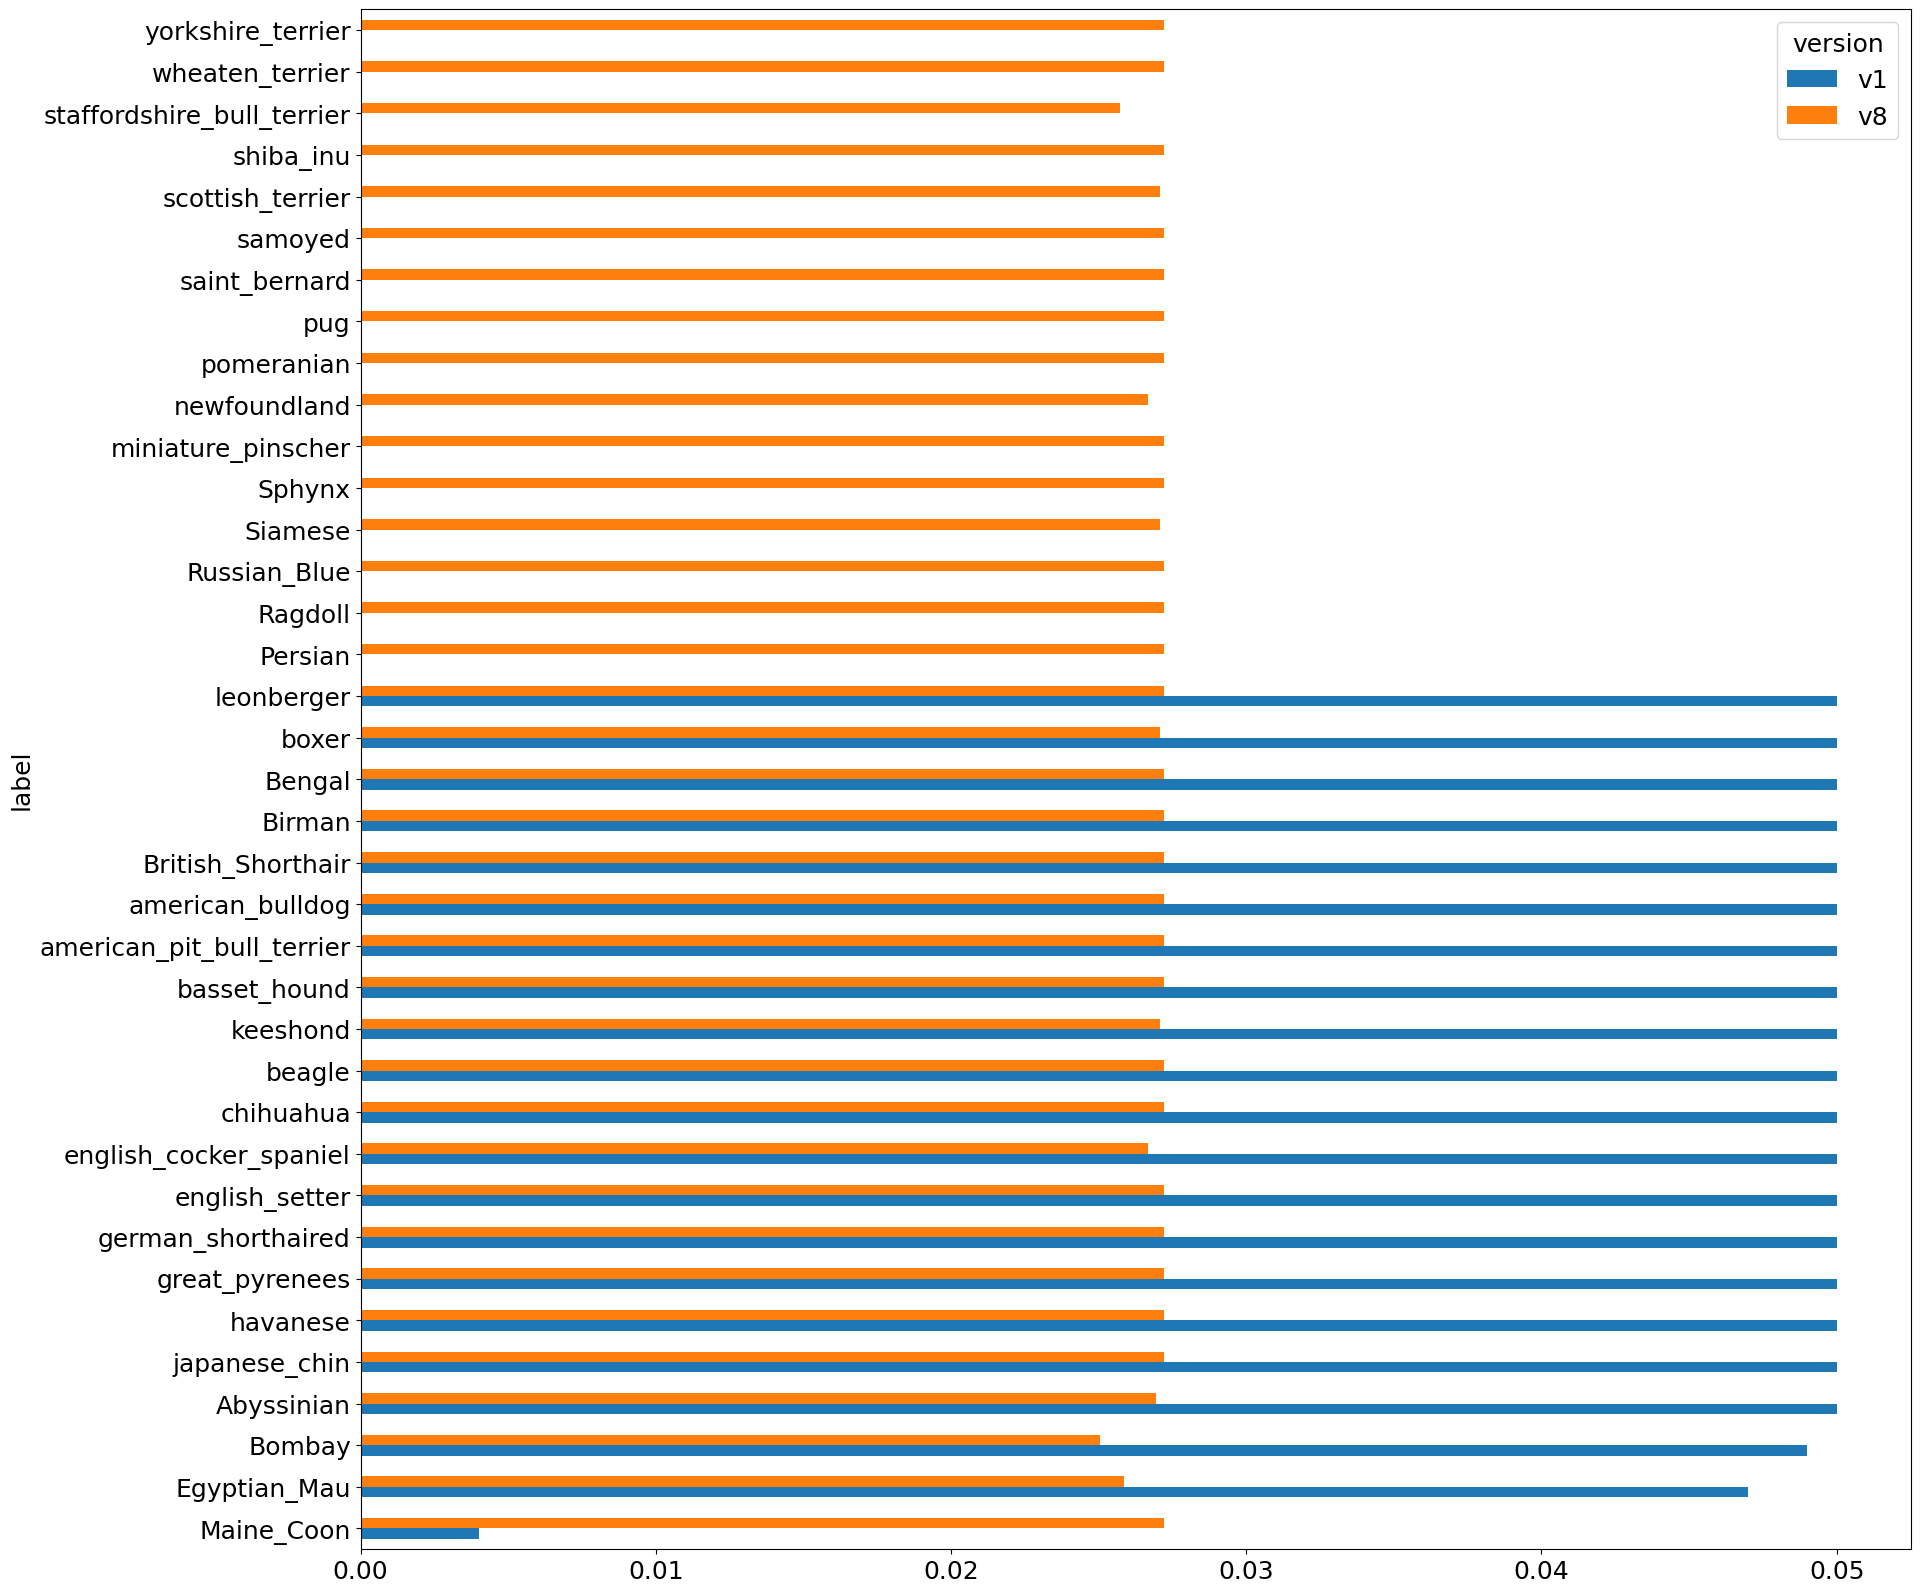

In [12]:
pivot_df = df.pivot(values='num_rows', index='label', columns='version')
pivot_df /= pivot_df.sum()
pivot_df.sort_values('v1').plot.barh(figsize=(20,20))

## Lance makes it easy to diff datasets

- A simple query can tell us data that's in the new version but not in the old version
- This makes it easy to go from high level summaries to drill-downs of individual examples

In [13]:
%%sql --lance

SELECT v8.external_image as _image
FROM v8 LEFT JOIN v1 ON v8._pk=v1._pk WHERE v1._pk IS NULL
LIMIT 20;

Took 0.0033800601959228516


## How does this all work?

1. Every time you add/update/delete rows/columns/cells, Lance creates a new version automatically
2. Data is written in multiple files. A single version will often include multiple files but a single file can never span multiple versions.
3. There's a pointer to the latest version so it's always accessible quickly.
4. Lance's Arrow integration hides the details but exposes a "version" parameter.

In [14]:
import pathlib

for p in pathlib.Path(uri).ls():
    print(str(p))
    if p.is_dir():
        for f in p.ls():
            print('  ' + str(f))

/tmp/pet.lance/_versions
  /tmp/pet.lance/_versions/8.manifest
  /tmp/pet.lance/_versions/2.manifest
  /tmp/pet.lance/_versions/3.manifest
  /tmp/pet.lance/_versions/5.manifest
  /tmp/pet.lance/_versions/4.manifest
  /tmp/pet.lance/_versions/1.manifest
  /tmp/pet.lance/_versions/6.manifest
  /tmp/pet.lance/_versions/7.manifest
/tmp/pet.lance/_latest.manifest
/tmp/pet.lance/data
  /tmp/pet.lance/data/a65f712b-0c98-4867-8d43-235adb9980ad_0.lance
  /tmp/pet.lance/data/02c33f78-151b-4cb0-bfca-e41af5a23276_0.lance
  /tmp/pet.lance/data/bd741e61-2901-4fb5-8ac8-49baedabe5dd_0.lance
  /tmp/pet.lance/data/dd62e66c-0ed5-4acd-aa83-94db0f2edfe9_0.lance
  /tmp/pet.lance/data/946dd9a4-489c-438f-bf02-0c89c97e6c12_0.lance
  /tmp/pet.lance/data/a4a499f3-d505-48a6-9016-087564f8ad2e_0.lance
  /tmp/pet.lance/data/74280958-9fe1-4bc5-95fd-cecab27029d1_0.lance
  /tmp/pet.lance/data/3d02b12c-dfc9-4c95-b3ec-b601c4e6298f_0.lance


Each manifest indicates which data files are included

In [15]:
!tail -n 5 /tmp/pet.lance/_versions/1.manifest

UnknownAbyssinianamerican_bulldogamerican_pit_bull_terrierbasset_houndbeagleBengalBirmanBombayboxerBritish_ShorthairchihuahuaEgyptian_Mauenglish_cocker_spanielenglish_settergerman_shorthairedgreat_pyreneeshavanesejapanese_chinkeeshondleonbergerMaine_Coonminiature_pinschernewfoundlandPersianpomeranianpugRagdollRussian_Bluesaint_bernardsamoyedscottish_terriershiba_inuSiameseSphynxstaffordshire_bull_terrierwheaten_terrieryorkshire_terrier                      !       :       F       L       R       X       ^       c       t       }       �       �       �       �       �       �       �       �       �       �                   #      -      0      7      C      P      W      g      p      w      }      �      �      �      UnknownCatDog�      �      �      �      trainvaltest      !      $      (      N  
_pk ��������*int168
#filename ���������*string8
7class ���������*dict:string:int8:false8B�&
9species ���������*dict:s

In [16]:
!tail -n 20 /tmp/pet.lance/_versions/8.manifest

UnknownAbyssinianamerican_bulldogamerican_pit_bull_terrierbasset_houndbeagleBengalBirmanBombayboxerBritish_ShorthairchihuahuaEgyptian_Mauenglish_cocker_spanielenglish_settergerman_shorthairedgreat_pyreneeshavanesejapanese_chinkeeshondleonbergerMaine_Coonminiature_pinschernewfoundlandPersianpomeranianpugRagdollRussian_Bluesaint_bernardsamoyedscottish_terriershiba_inuSiameseSphynxstaffordshire_bull_terrierwheaten_terrieryorkshire_terrier                      !       :       F       L       R       X       ^       c       t       }       �       �       �       �       �       �       �       �       �       �                   #      -      0      7      C      P      W      g      p      w      }      �      �      �      UnknownCatDog�      �      �      �      trainvaltest      !      $      (      �  
_pk ��������*int168
#filename ���������*string8
7class ���������*dict:string:int8:false8B�&
9species ���������*dict:s

## Conclusion

1. Dataset versioning is crucial for reproducibility and model debugging
2. Lance makes the versioning process transparent and automatic
3. Lance makes all versions concurrently queryable by any Arrow-compatible SQL or DataFrame interface
4. You can compare distributions and metrics across versions, find data differences across versions, and pin-point top error contributors to fix regressions, all without any additional infrastructure

## Roadmap


- Currently we support "append rows" operations
  - Updates and deletes are forthcoming
  - "As of" timestamp is forthcoming so you don't need to remember explicit versions